## Creative Content Assisted by Generative AI using Amazon SageMaker: Inpainting Eraser
---
In this notebook, we will demonstrate how to create a Inpainting eraser that can remove any object from an image using Amazon SageMaker. This tool can come in handy when you need to remove photobombs, get rid of unwanted objects, or even clean up backgrounds. 

Our solution for inpainting eraser involves two main steps. The first step is to create a segmentation mask of the object to be removed based on a pixel coordinate input. Then second step is to “erase”, which fills the area using the contexts from the rest of the image. 

To generate segmentation, we used a foundation model developed by Meta Research called **[Segment Anything Model (SAM)](https://segment-anything.com/) - Apache-2.0 license**. This model is trained on a massive dataset called SA-1B with over 11 million images and 1.1 billion segmentation masks.  This massive scale gave Sam model unprecedented ability to identify and isolate objects from an image out of the box without training.

To erase the object, we used a second model called **[Resolution-robust Large Mask Inpainting with Fourier Convolutions (LaMa)](https://advimman.github.io/lama-project/) - Apache-2.0 license** developed by Roman Suvorov. This model can fill in missing parts of images caused by irregular masks.

**Note: please run the `0_setup.ipynb` notebook first before starting on this example. We recommend to use pytorch kernel on SageMaker Notebook Instance using `ml.g4dn.xlarge`**

### Setup

In [14]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

from matplotlib import pyplot as plt
import io
import base64

import time

from PIL import Image
import numpy as np
import json

%matplotlib inline  

role = get_execution_role()

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
s3 = boto3.client('s3')

sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
region = sagemaker_session.boto_region_name
account = sagemaker_session.account_id()
bucket = sagemaker_session.default_bucket()
prefix = 'magic-eraser'

%store -r extended_triton_image_uri

## Serve models wtih Triton inference server

We will use Triton Python backend to deploy and host these models on SageMaker MME. Triton server requires our models to be package in following folder structure. We can find these already provided in the `model_repo` folder.
```
|-model_repo
    |---sam
        |----1
             |--model.py
        |----config.pbtxt
    |---lama
        |----1
             |--model.py
        |----config.pbtxt
```

We are using Python backend to load our models. In order to use Python backend, you will need at least a Triton config file and a Python file named `model.py`. Let's explore the structure for each file. 

`config.pbtxt` is a manditory configuration file for Triton that config the backend type, batch size, input, output format, etc.

In [15]:
!cat model_repo/sam/config.pbtxt

name: "sam"
backend: "python"
max_batch_size: 8
input [
  {
    name: "image"
    data_type: TYPE_STRING
    dims: [-1]
  },
  {
    name: "gen_args"
    data_type: TYPE_STRING
    dims: [-1]
    optional: true
  }
]
output [
  {
    name: "generated_image"
    data_type: TYPE_STRING    
    dims: [-1]
  }
]
instance_group [
  {
    kind: KIND_GPU
  }
]
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "/home/condpackenv/sam_env.tar.gz"
  }
}

Python backend script needs to define a TritonPythonModel class with four potential functions. Refer to [Triton Python backend documentation](https://github.com/triton-inference-server/python_backend) for more details

```python
import triton_python_backend_utils as pb_utils
class TritonPythonModel:
    """Your Python model must use the same class name. Every Python model
    that is created must have "TritonPythonModel" as the class name.
    """
    def auto_complete_config(auto_complete_model_config):
    def initialize(self, args):
    def execute(self, requests):
    def finalize(self):
```

In [16]:
!cat model_repo/sam/1/model.py

import json
import base64

from PIL import Image
from six import BytesIO

import numpy as np
import cv2
import os

import triton_python_backend_utils as pb_utils

from segment_anything import SamPredictor, sam_model_registry

class TritonPythonModel:
    
    def initialize(self, args):
        self.output_dtype = pb_utils.triton_string_to_numpy(
            pb_utils.get_output_config_by_name(json.loads(args["model_config"]),
                                               "generated_image")["data_type"])
        
        self.model_dir = args['model_repository']
    
        device='cuda'
        
        sam = sam_model_registry["vit_h"](checkpoint=f"/home/models/sam_vit_h_4b8939.pth").to(device)
        
        self.predictor = SamPredictor(sam)

    def encode_image(self, img): 
        # Convert the image to bytes
        with BytesIO() as output:
            img.save(output, format="JPEG")
            img_bytes = output.getvalue()

        return base64.b64encode(img_bytes).decod

## Deploy Models to MME

In [17]:
!rm -rf `find -type d -name .ipynb_checkpoints`  
!find . | grep -E "(__pycache__|\.pyc$)" | xargs sudo rm -rf 

In [18]:
model_dir = "model_repo"
models = ["sam", "lama"]
v_ = 0

model_targets = dict()
for m in models:
    
    tar_name = f"{m}-v{v_}.tar.gz"
    model_targets[m] = tar_name

    !tar -C $model_dir -zcvf $tar_name $m
    
    sagemaker_session.upload_data(path=tar_name, key_prefix=f"{prefix}/models")

    
print(model_targets)

sam/
sam/1/
sam/1/model.py
sam/config.pbtxt
lama/
lama/1/
lama/1/model.py
lama/1/lama/
lama/1/lama/fetch_data/
lama/1/lama/fetch_data/celebahq_dataset_prepare.sh
lama/1/lama/fetch_data/sampler.py
lama/1/lama/fetch_data/places_challenge_train_download.sh
lama/1/lama/fetch_data/train_shuffled.flist
lama/1/lama/fetch_data/places_standard_test_val_sample.sh
lama/1/lama/fetch_data/places_standard_train_prepare.sh
lama/1/lama/fetch_data/val_shuffled.flist
lama/1/lama/fetch_data/celebahq_gen_masks.sh
lama/1/lama/fetch_data/places_standard_test_val_prepare.sh
lama/1/lama/fetch_data/places_standard_evaluation_prepare_data.sh
lama/1/lama/fetch_data/places_standard_test_val_gen_masks.sh
lama/1/lama/fetch_data/eval_sampler.py
lama/1/lama/README.md
lama/1/lama/configs/
lama/1/lama/configs/places2-categories_157.txt
lama/1/lama/configs/analyze_mask_errors.yaml
lama/1/lama/configs/eval2_jpg.yaml
lama/1/lama/configs/eval2_test.yaml
lama/1/lama/configs/training/
lama/1/lama/configs/training/big-lama-re

lama/1/lama/.git/objects/pack/pack-6921fa77d932060ecdcbba7c410b4edb5868c21c.idx
lama/1/lama/.git/index
lama/1/lama/.git/HEAD
lama/1/lama/.git/branches/
lama/1/lama/.git/refs/
lama/1/lama/.git/refs/tags/
lama/1/lama/.git/refs/remotes/
lama/1/lama/.git/refs/remotes/origin/
lama/1/lama/.git/refs/remotes/origin/HEAD
lama/1/lama/.git/refs/heads/
lama/1/lama/.git/refs/heads/main
lama/1/lama/.git/config
lama/1/lama/.git/description
lama/1/lama/.git/hooks/
lama/1/lama/.git/hooks/prepare-commit-msg.sample
lama/1/lama/.git/hooks/pre-commit.sample
lama/1/lama/.git/hooks/push-to-checkout.sample
lama/1/lama/.git/hooks/pre-applypatch.sample
lama/1/lama/.git/hooks/post-update.sample
lama/1/lama/.git/hooks/commit-msg.sample
lama/1/lama/.git/hooks/fsmonitor-watchman.sample
lama/1/lama/.git/hooks/applypatch-msg.sample
lama/1/lama/.git/hooks/pre-rebase.sample
lama/1/lama/.git/hooks/pre-merge-commit.sample
lama/1/lama/.git/hooks/pre-push.sample
lama/1/lama/.git/hooks/pre-receive.sample
lama/1/lama/.git/ho

**Define the Serving Container**

Start with a container definition. Define the ModelDataUrl to specify the S3 directory that contains all the models that SageMaker multi-model endpoint will use to load and serve predictions. Set Mode to MultiModel to indicates SageMaker would create the endpoint with MME container specifications. 

In [19]:
model_data_url = f"s3://{bucket}/{prefix}/models/"
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": extended_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
}


**Setup SM Model**

Using the SageMaker boto3 client, create the model using [create_model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model) API. We will pass the container definition to the create model API along with ModelName and ExecutionRoleArn.

In [20]:
sm_model_name = f"{prefix}-models-{ts}"

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-west-2:376678947624:model/magic-eraser-models-2024-01-17-05-08-03


**Create a SageMaker endpoint configuration.**

Create a multi-model endpoint configuration using [create_endpoint_config](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint_config) boto3 API. Specify an accelerated GPU computing instance in InstanceType (we will use the same instance type that we are using to host our SageMaker Notebook). We recommend configuring your endpoints with at least two instances with real-life use-cases. This allows SageMaker to provide a highly available set of predictions across multiple Availability Zones for the models.

In [21]:
endpoint_config_name = f"{prefix}-config-{ts}"
instance_type = 'ml.g5.2xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint-config/magic-eraser-config-2024-01-17-05-08-03


**Create endpoint**

Using the above endpoint configuration we create a new sagemaker endpoint and wait for the deployment to finish. The status will change to **InService** once the deployment is successful.

In [22]:
endpoint_name = f"{prefix}-ep-{ts}"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint/magic-eraser-ep-2024-01-17-05-08-03
Status: InService


## Invoking the models

Now we can test our models. We want to firt call the sam model to generate a segmentation mask. 

---

### Invoke SAM model
This primary input for this model is the image and the [x, y] coordinates of the image pixle to locate the object. We need to encode the image into bytes before sending it to the endpoint.

Optionally, you can also   pass in `point_labels` if you need segment object in multiple class. or `dilate_kernel_size` if you need to play with the sharpness of the mask. 

In [23]:
def encode_image(img):
    
    # Convert the image to bytes
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        img_bytes = output.getvalue()
    
    return base64.b64encode(img_bytes).decode('utf8')

Here is how you can invoke the SageMaker MME

Original Image


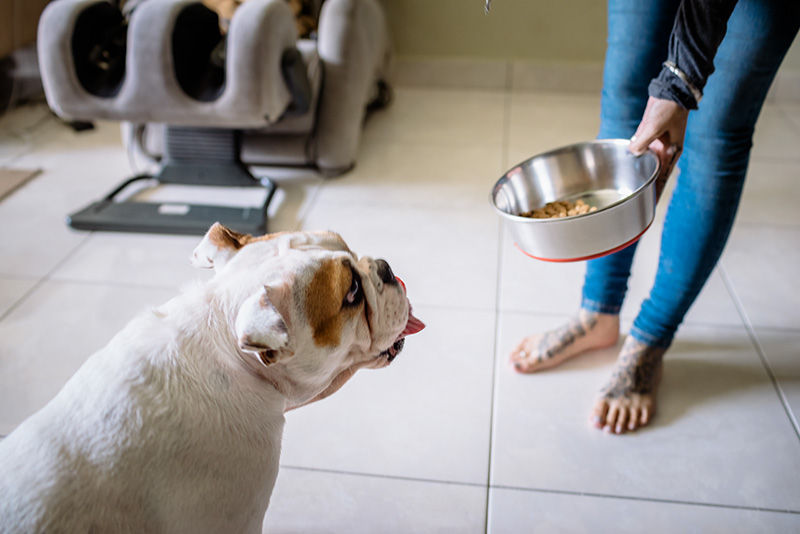

In [24]:
# pixle coordinate of dog in dog.jpg is 200, 450
# pixle coordinate of dog in sample1.png is 750, 500
img_file='statics/dog.jpg'
original_image = Image.open(img_file)

print("Original Image")
display(original_image)
original_image_bytes = encode_image(original_image)

gen_args = json.dumps(dict(point_coords=[200, 450], point_labels=1, dilate_kernel_size=15))

inputs = dict(image=original_image_bytes,
              gen_args = gen_args)

payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

Notice when you invoke the model the first time, the latency is much higher due to cold start. Every subsequent calls will be much faster because the model is cached in memory.

In [25]:
%%time
response = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/octet-stream",
        Body=json.dumps(payload),
        TargetModel=model_targets["sam"], 
    )

CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 37.5 s


Object Mask


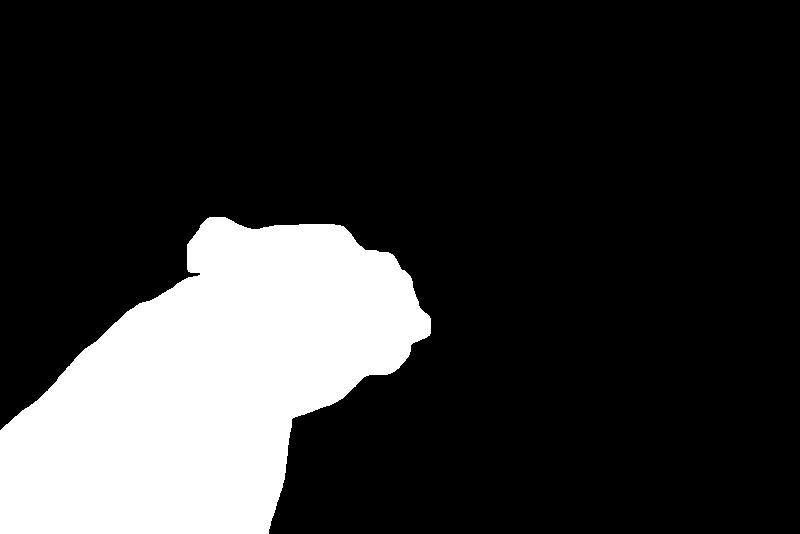

In [26]:
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
mask_decoded = io.BytesIO(base64.b64decode(output[0]["data"][0]))
mask_rgb = Image.open(mask_decoded).convert("RGB")

print("Object Mask")
display(mask_rgb)

### Invoke LaMa Model

now supply the original image and previously generated mask to the LaMa model, and we can "erase" the object from the image.

In [27]:
# Inputs ==================
# original_image_bytes
mask_image = encode_image(mask_rgb)

inputs = dict(image=original_image_bytes,
              mask_image=mask_image)

payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

In [28]:
%%time
response = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/octet-stream",
        Body=json.dumps(payload),
        TargetModel=model_targets["lama"], 
    )

CPU times: user 22.6 ms, sys: 374 µs, total: 23 ms
Wall time: 48.4 s


Object Erased


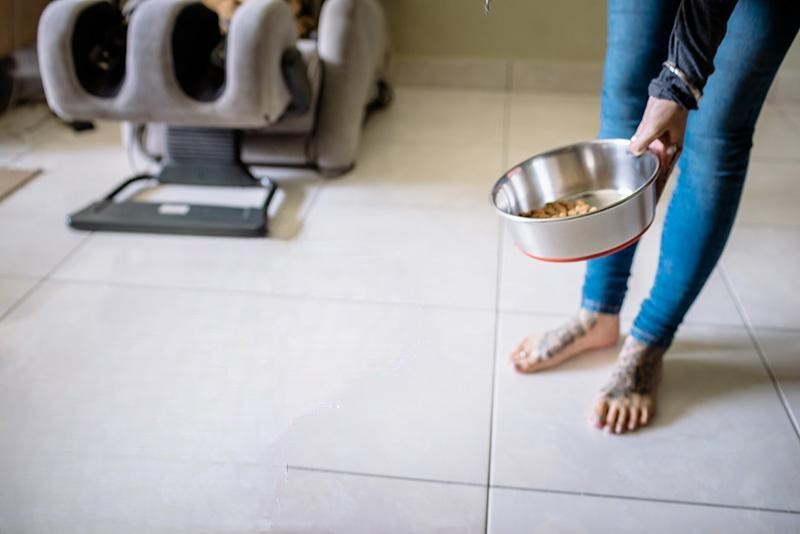

In [29]:
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
mask_decoded = io.BytesIO(base64.b64decode(output[0]["data"][0]))
mask_rgb = Image.open(mask_decoded).convert("RGB")

print("Object Erased")
display(mask_rgb)

### [Optional] Gradio UI
Write configuration file for the Gradio app

In [ ]:
config = dict()
config["endpoint_name"] = endpoint_name
config["models"] = model_targets

with open("config.json", 'w') as f:
    json.dump(config, f)

1) Open up a system terminal and navigate into this folder

2) install packages. most important is to pip install `gradio`

```
pip install -r requirements.txt
```
3) run the following commend to launch the app
```
python run.py
```

4) click on the public link to open up the ui in your browser.

### Clean Up
When you are done delete the endpoint to stop incurring charges

In [37]:
response = sm_client.delete_endpoint(
    EndpointName=endpoint_name
)